# Введение

Целью нашего проекта является разработка решения, которое позволит персонализировать предложения для постоянных клиентов магазина с целью увеличения их покупательской активности. Мы стремимся использовать данные аналитики и бизнес-моделирования для создания индивидуальных предложений, способствующих удержанию клиентов и увеличению объемов продаж.

Для реализации этой цели нам предстоит работать в отделе цифровых технологий "В один клик", где мы будем анализировать данные о покупках, предпочтениях и поведении клиентов, чтобы выявить ключевые моменты, влияющие на их решения о покупке. Наше решение будет основано на анализе данных и бизнес-моделировании, что позволит нам предложить персонализированные рекомендации для каждого клиента.

Мы уверены, что разработанное решение поможет "В один клик" увеличить лояльность постоянных клиентов и повысить их участие в покупках, что в конечном итоге приведет к росту выручки и укреплению позиций на рынке.

## Загрузка данных

In [1]:
!pip install shap -q # -q убирает необязательные выводы в командах Linux
!pip install phik
!pip install -Uq scikit-learn

In [2]:
# импорты для работы с данными
import pandas as pd
import numpy as np
# импорты для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
# импорты для машинного обучения
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
# импорты для интерпритации моделей и анализа данных
import shap
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix

In [3]:
df_market_file = pd.read_csv('/datasets/market_file.csv')
df_market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
df_market_time = pd.read_csv('/datasets/market_time.csv')
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


## Предобработка данных

In [11]:
df_market_file.duplicated().sum()

0

In [12]:
df_market_file.isnull().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [13]:
df_market_file.head(2)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


In [14]:
def unique_values(df, column_name):
    unique_values = df[column_name].unique()
    print(unique_values)

In [15]:
unique_values(df_market_file, 'Покупательская активность')
unique_values(df_market_file, 'Тип сервиса')
unique_values(df_market_file, 'Разрешить сообщать')
unique_values(df_market_file, 'Популярная_категория')

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [16]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт', 'стандарт')

In [17]:
unique_values(df_market_file, 'Тип сервиса')

['премиум' 'стандарт']


In [18]:
df_market_time.head(2)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


In [19]:
df_market_time.duplicated().sum()

0

In [20]:
df_market_time.isnull().sum()

id        0
Период    0
минут     0
dtype: int64

In [21]:
unique_values(df_market_time, 'Период')

['текущий_месяц' 'предыдцщий_месяц']


In [22]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
unique_values(df_market_time, 'Период')

['текущий_месяц' 'предыдущий_месяц']


In [23]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [24]:
df_market_money.duplicated().sum()

0

In [25]:
df_market_money.isnull().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [26]:
unique_values(df_market_money, 'Период')

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [27]:
df_money.duplicated().sum()

0

In [28]:
df_money.isnull().sum()

id         0
Прибыль    0
dtype: int64

## Исследовательский анализ данных

In [29]:
df_market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [30]:
def pivot_table_and_chart(data, column_name, values, title, aggfunc):
    #создаём сводную таблицу
    pivot_table = data.pivot_table(index='Покупательская активность', 
                                   values=values, 
                                   aggfunc=aggfunc)
    #строим график
    ax = sns.barplot(x=values, y=pivot_table.index, data=pivot_table, ci=None, palette='viridis')
    # добавляем значение к столбцам
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.3f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha = 'right', va = 'center',
                    xytext = (0, 0),
                    textcoords = 'offset points')
    #настраиваем оси и заголовки
    plt.xlabel(values)
    plt.ylabel(column_name)
    plt.title(title)
    plt.tight_layout()

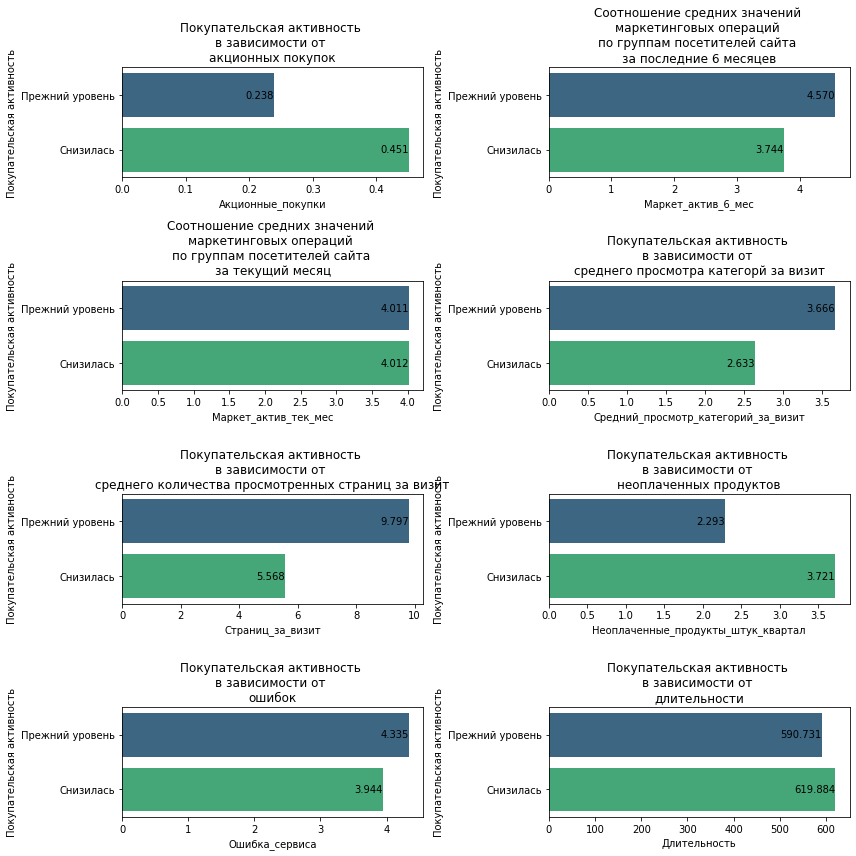

In [31]:
plt.figure(figsize=(12, 12))
plt.subplot(4, 2, 1)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Акционные_покупки', 
                      'Покупательская активность \nв зависимости от \nакционных покупок', 'mean')
plt.subplot(4, 2, 2)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Маркет_актив_6_мес', 
                      'Соотношение средних значений \nмаркетинговых операций \nпо группам посетителей сайта \nза последние 6 месяцев', 'mean')
plt.subplot(4, 2, 3)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Маркет_актив_тек_мес', 
                      'Соотношение средних значений \nмаркетинговых операций \nпо группам посетителей сайта \nза текущий месяц', 'mean')
plt.subplot(4, 2, 4)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Средний_просмотр_категорий_за_визит', 
                      'Покупательская активность \nв зависимости от \nсреднего просмотра категорй за визит', 'mean')
plt.subplot(4, 2, 5)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Страниц_за_визит', 
                      'Покупательская активность \nв зависимости от \nсреднего количества просмотренных страниц за визит', 
                      'mean')
plt.subplot(4, 2, 6)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Неоплаченные_продукты_штук_квартал', 
                      'Покупательская активность \nв зависимости от \nнеоплаченных продуктов', 'mean')
plt.subplot(4, 2, 7)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Ошибка_сервиса', 
                      'Покупательская активность \nв зависимости от \nошибок', 
                      'mean')
plt.subplot(4, 2, 8)
pivot_table_and_chart(df_market_file, 'Покупательская активность', 'Длительность', 
                      'Покупательская активность \nв зависимости от \nдлительности', 
                      'mean')
plt.show()

**Выводы** 

**График 1:** Среди посетителей сайта, у которых покупательская активность не изменилась, среднее значение доли покупок по акции составляет 0.238, а среди тех, у кого активность снизилась, это значение равно 0.451. Эти цифры показывают, что покупательская активность снизилась у той группы посетителей, которая более активно пользуется покупками по акции. Таким образом, можно предположить, что увеличение доли покупок по акции среди посетителей связано с снижением покупательской активности в целом.

**График 2:** Среди посетителей сайта, у которых покупательская активность осталась на том же уровне, среднее количество маркетинговых коммуникаций (рассылки, показы, звонки и т.д.) за последние 6 месяцев составляет 4.570, в то время как среди тех, у кого активность снизилась, это значение равно 3.744. Эти данные указывают на то, что покупательская активность снизилась в группе посетителей, которая была менее подвержена маркетинговым коммуникациям за последнии 6 месяцев. Таким образом, можно сделать вывод о связи между активностью взаимодействия с маркетинговыми коммуникациями и уровнем покупательской активности.

**График 3:** Для посетителей сайта, у которых покупательская активность осталась на том же уровне, среднее количество маркетинговых коммуникаций за текущий месяц составляет 4.011, для посетителей, у которых активность снизилась, это значение равно 4.012. Наблюдается практически отсутствие различия в среднем количестве коммуникаций между этими двумя группами, что может указывать на то, что количество маркетинговых коммуникаций не оказывает влияния на уровень покупательской активности.

**График 4 и 5:** Среднее количество просмотренных категорий и страниц сайта у посетителей, у которых покупательская активность осталась на том же уровне, статистически значимо выше, чем у тех, у кого активность снизилась. Это подтверждает предположение о том, что с уменьшением покупательской активности снижается и интерес к различным категориям товаров или услуг, что может быть важным фактором для анализа и оптимизации маркетинговых стратегий для каждой из этих групп посетителей.

**График 6:** Количество неоплаченных продуктов выше у посетителей, у которых активность снизилась, и равно 3.712, в то время как у посетителей, у которых активность осталась на прежнем уровне, составляет 2.293. Это является логичным, так как с уменьшением покупательской активности вероятность добавления продуктов в корзину без последующей оплаты увеличивается.

**График 7:** Исходя из предоставленных данных, увеличение количества ошибок не оказывает значительного влияния на снижение покупательской активности. Этот вывод подтверждается количеством ошибок у пользователей, у которых активность осталась на прежнем уровне (4.335), по сравнению с количеством ошибок у посетителей, у которых активность снизилась (3.944). Таким образом, другие факторы, вероятно, оказывают более значимое влияние на уровень покупательской активности.

**График 8:** Из предоставленных данных следует, что с течением времени с момента регистрации и начала использования сайта уровень активности посетителей снижается. Этот вывод подтверждается более длительным периодом регистрации на сайте у пользователей, у которых активность снизилась (619.884 дней), по сравнению с пользователями, у которых активность осталась на прежнем уровне (590.731 дней). Таким образом, для удержания и стимулирования активности посетителей необходимо проводить анализ и оптимизацию мероприятий по взаимодействию с ними на различных этапах их пользовательского опыта.

In [32]:
def box_chart(df, column_name):
    sns.boxplot(data=df[column_name], orient='h')

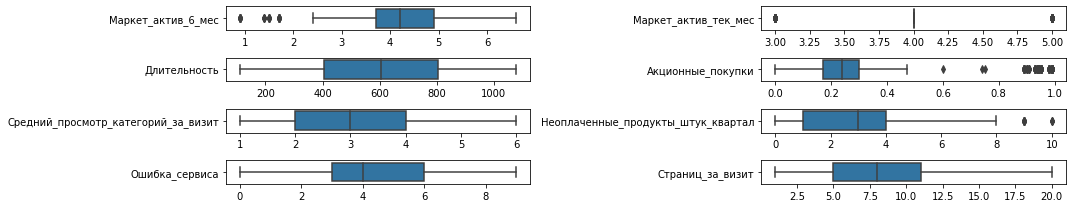

In [33]:
plt.figure(figsize=(15, 3))
plt.subplot(4, 2, 1)
box_chart(df_market_file, ['Маркет_актив_6_мес'])
plt.subplot(4, 2, 2)
box_chart(df_market_file, ['Маркет_актив_тек_мес'])
plt.subplot(4, 2, 3)
box_chart(df_market_file, ['Длительность'])
plt.subplot(4, 2, 4)
box_chart(df_market_file, ['Акционные_покупки'])
plt.subplot(4, 2, 5)
box_chart(df_market_file, ['Средний_просмотр_категорий_за_визит'])
plt.subplot(4, 2, 6)
box_chart(df_market_file, ['Неоплаченные_продукты_штук_квартал'])
plt.subplot(4, 2, 7)
box_chart(df_market_file, ['Ошибка_сервиса'])
plt.subplot(4, 2, 8)
box_chart(df_market_file, ['Страниц_за_визит'])
plt.tight_layout()
plt.show()

In [34]:
active_users = df_market_money[df_market_money['Выручка'] > 0].groupby('id')['Период'].nunique()
active_users = active_users[active_users == 3].index.tolist()
active_users
filtered_df_market_money = df_market_money[df_market_money['id'].isin(active_users)]
filtered_df_market_money.head()

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [35]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [36]:
pivot_df_service_type = df_market_file.pivot_table(index='Тип сервиса', 
                           columns='Покупательская активность', 
                           values='Разрешить сообщать', 
                           aggfunc='count')
pivot_df_service_type['% - прежний'] = round((pivot_df_service_type['Прежний уровень'] 
                                               / (pivot_df_service_type['Прежний уровень'] 
                                                  + pivot_df_service_type['Снизилась'])) * 100, 1)
pivot_df_service_type

Покупательская активность,Прежний уровень,Снизилась,% - прежний
Тип сервиса,,,
премиум,206,170,54.8
стандарт,596,328,64.5


**Вывод:**  
Из представленных данных следует, что процент посетителей сайта, уровень активности которых остался на прежнем уровне, выше среди пользователей стандартного сервиса по сравнению с премиум. Для премиум-сервиса этот процент составляет 54.8%, в то время как для стандартного сервиса - 64.5%. Таким образом, можно сделать вывод, что пользователи стандартного сервиса в целом более лояльны и делают покупки на сайте в большей степени, чем пользователи премиум-сервиса.

In [37]:
pivot_df_popular_cat = df_market_file.pivot_table(index='Популярная_категория', 
                           columns='Покупательская активность', 
                           values='Разрешить сообщать', 
                           aggfunc='count')
pivot_df_popular_cat['% - прежний уровень'] = round((pivot_df_popular_cat['Прежний уровень'] 
                                               / (pivot_df_popular_cat['Прежний уровень'] 
                                                  + pivot_df_popular_cat['Снизилась'])) * 100, 1)
pivot_df_popular_cat['% - от общего числа'] = round(((pivot_df_popular_cat['Прежний уровень']
                                               +pivot_df_popular_cat['Снизилась'])
                                               /(pivot_df_popular_cat['Прежний уровень'].sum()
                                               +pivot_df_popular_cat['Снизилась'].sum())) * 100, 1)
pivot_df_popular_cat

Покупательская активность,Прежний уровень,Снизилась,% - прежний уровень,% - от общего числа
Популярная_категория,,,,
Домашний текстиль,149,102,59.4,19.3
Косметика и аксесуары,118,105,52.9,17.2
Кухонная посуда,72,66,52.2,10.6
Мелкая бытовая техника и электроника,147,27,84.5,13.4
Техника для красоты и здоровья,132,52,71.7,14.2
Товары для детей,184,146,55.8,25.4


**Вывод:**  
Пользователи, приобретающие товары из категорий "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья", демонстрируют более высокую покупательскую активность: у 84.5% и 71.7% соответственно активность осталась на прежнем уровне. Тем не менее, их доля среди общего числа пользователей относительно меньше, чем у других групп. Самые многочисленные группы пользователей - это покупатели товаров для детей и домашнего текстиля, которые составляют 25.4% и 19.3% соответственно от общего числа пользователей. Несмотря на это, у них наблюдается средний уровень активности. Для увеличения общей покупательской активности рекомендуется сохранять уровень активности пользователей, выбирающих технику и товары для красоты и здоровья, а также мотивировать пользователей, приобретающих товары для детей и текстиль и в не меньшей степени всех остальных групп, к совершению покупок.

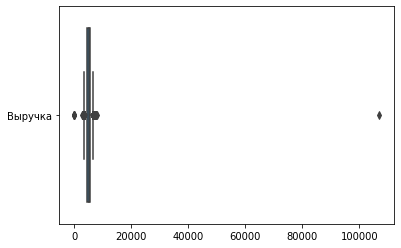

In [38]:
box_chart(df_market_money, ['Выручка'])

In [39]:
df_market_money = df_market_money[df_market_money['Выручка'] < 100000]

In [40]:
df_market_money['Выручка'].describe()

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: Выручка, dtype: float64

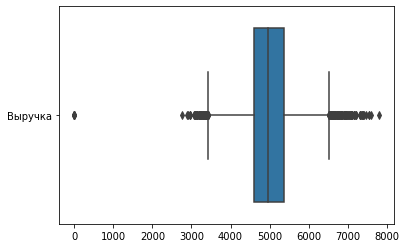

In [41]:
box_chart(df_market_money, ['Выручка'])

In [42]:
df_market_money[df_market_money['Выручка'] == 0]['id'].unique()

array([215348, 215357, 215359])

In [43]:
df_market_money = df_market_money[~df_market_money['id'].isin([215348, 215357, 215359])]

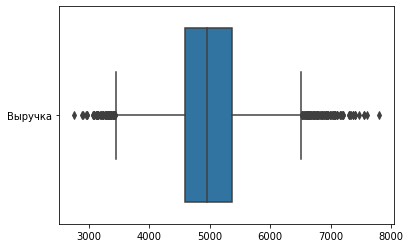

In [44]:
box_chart(df_market_money, ['Выручка'])

In [45]:
df_market_money.pivot_table(index='id', values='Выручка', aggfunc='sum').sort_values(by='Выручка', ascending=False).head()

,Выручка
id,
215841,19766.5
215435,19482.8
215493,19385.9
216144,18976.3
215558,18838.8


In [46]:
df_market_money.pivot_table(index='Период', values='Выручка', aggfunc='sum')

,Выручка
Период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6788572.5


In [47]:
df_market_money['Выручка'].sum()

19479338.0

In [48]:
df_market_money[df_market_money['Выручка'] > 0].pivot_table(index='Период', values='Выручка', aggfunc='count')

,Выручка
Период,
предыдущий_месяц,1297
препредыдущий_месяц,1297
текущий_месяц,1296


In [49]:
df_market_money[df_market_money['Выручка'] == 0]

,id,Период,Выручка


In [50]:
money_pivot_table = df_market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum')
money_pivot_table['Разница м/у текущим и предыдущим'] = money_pivot_table['текущий_месяц'] - money_pivot_table['предыдущий_месяц']
money_pivot_table['Разница м/у предыдущим и препредыдущим'] = money_pivot_table['предыдущий_месяц'] - money_pivot_table['препредыдущий_месяц']
money_pivot_table['Сумма разниц'] = money_pivot_table['Разница м/у текущим и предыдущим'] + money_pivot_table['Разница м/у предыдущим и препредыдущим']
money_pivot_table[money_pivot_table['Сумма разниц'] < 0].sort_values(by='Сумма разниц', ascending=True).head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,Разница м/у текущим и предыдущим,Разница м/у предыдущим и препредыдущим,Сумма разниц
id,,,,,,
215466,3202.0,4748.0,2758.7,-443.3,-1546.0,-1989.3
215560,3137.0,4931.0,3083.7,-53.3,-1794.0,-1847.3
216243,4438.0,5485.0,3660.6,-777.4,-1047.0,-1824.4
216015,4466.0,5492.0,3706.8,-759.2,-1026.0,-1785.2
216405,4637.0,5663.0,3877.8,-759.2,-1026.0,-1785.2


In [51]:
df_market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

In [52]:
df_market_time['минут'].sum()

34674

In [53]:
df_market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [54]:
df_market_time.pivot_table(index='Период', values='минут', aggfunc='sum')

,минут
Период,
предыдущий_месяц,17508
текущий_месяц,17166


In [55]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

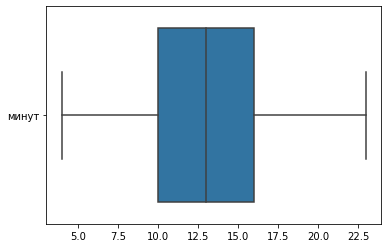

In [56]:
box_chart(df_market_time, ['минут'])

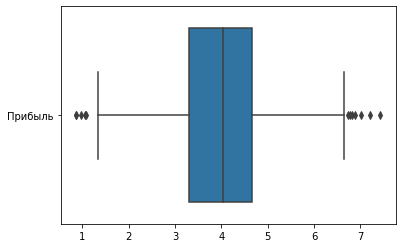

In [57]:
box_chart(df_money, ['Прибыль'])

In [58]:
df_money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

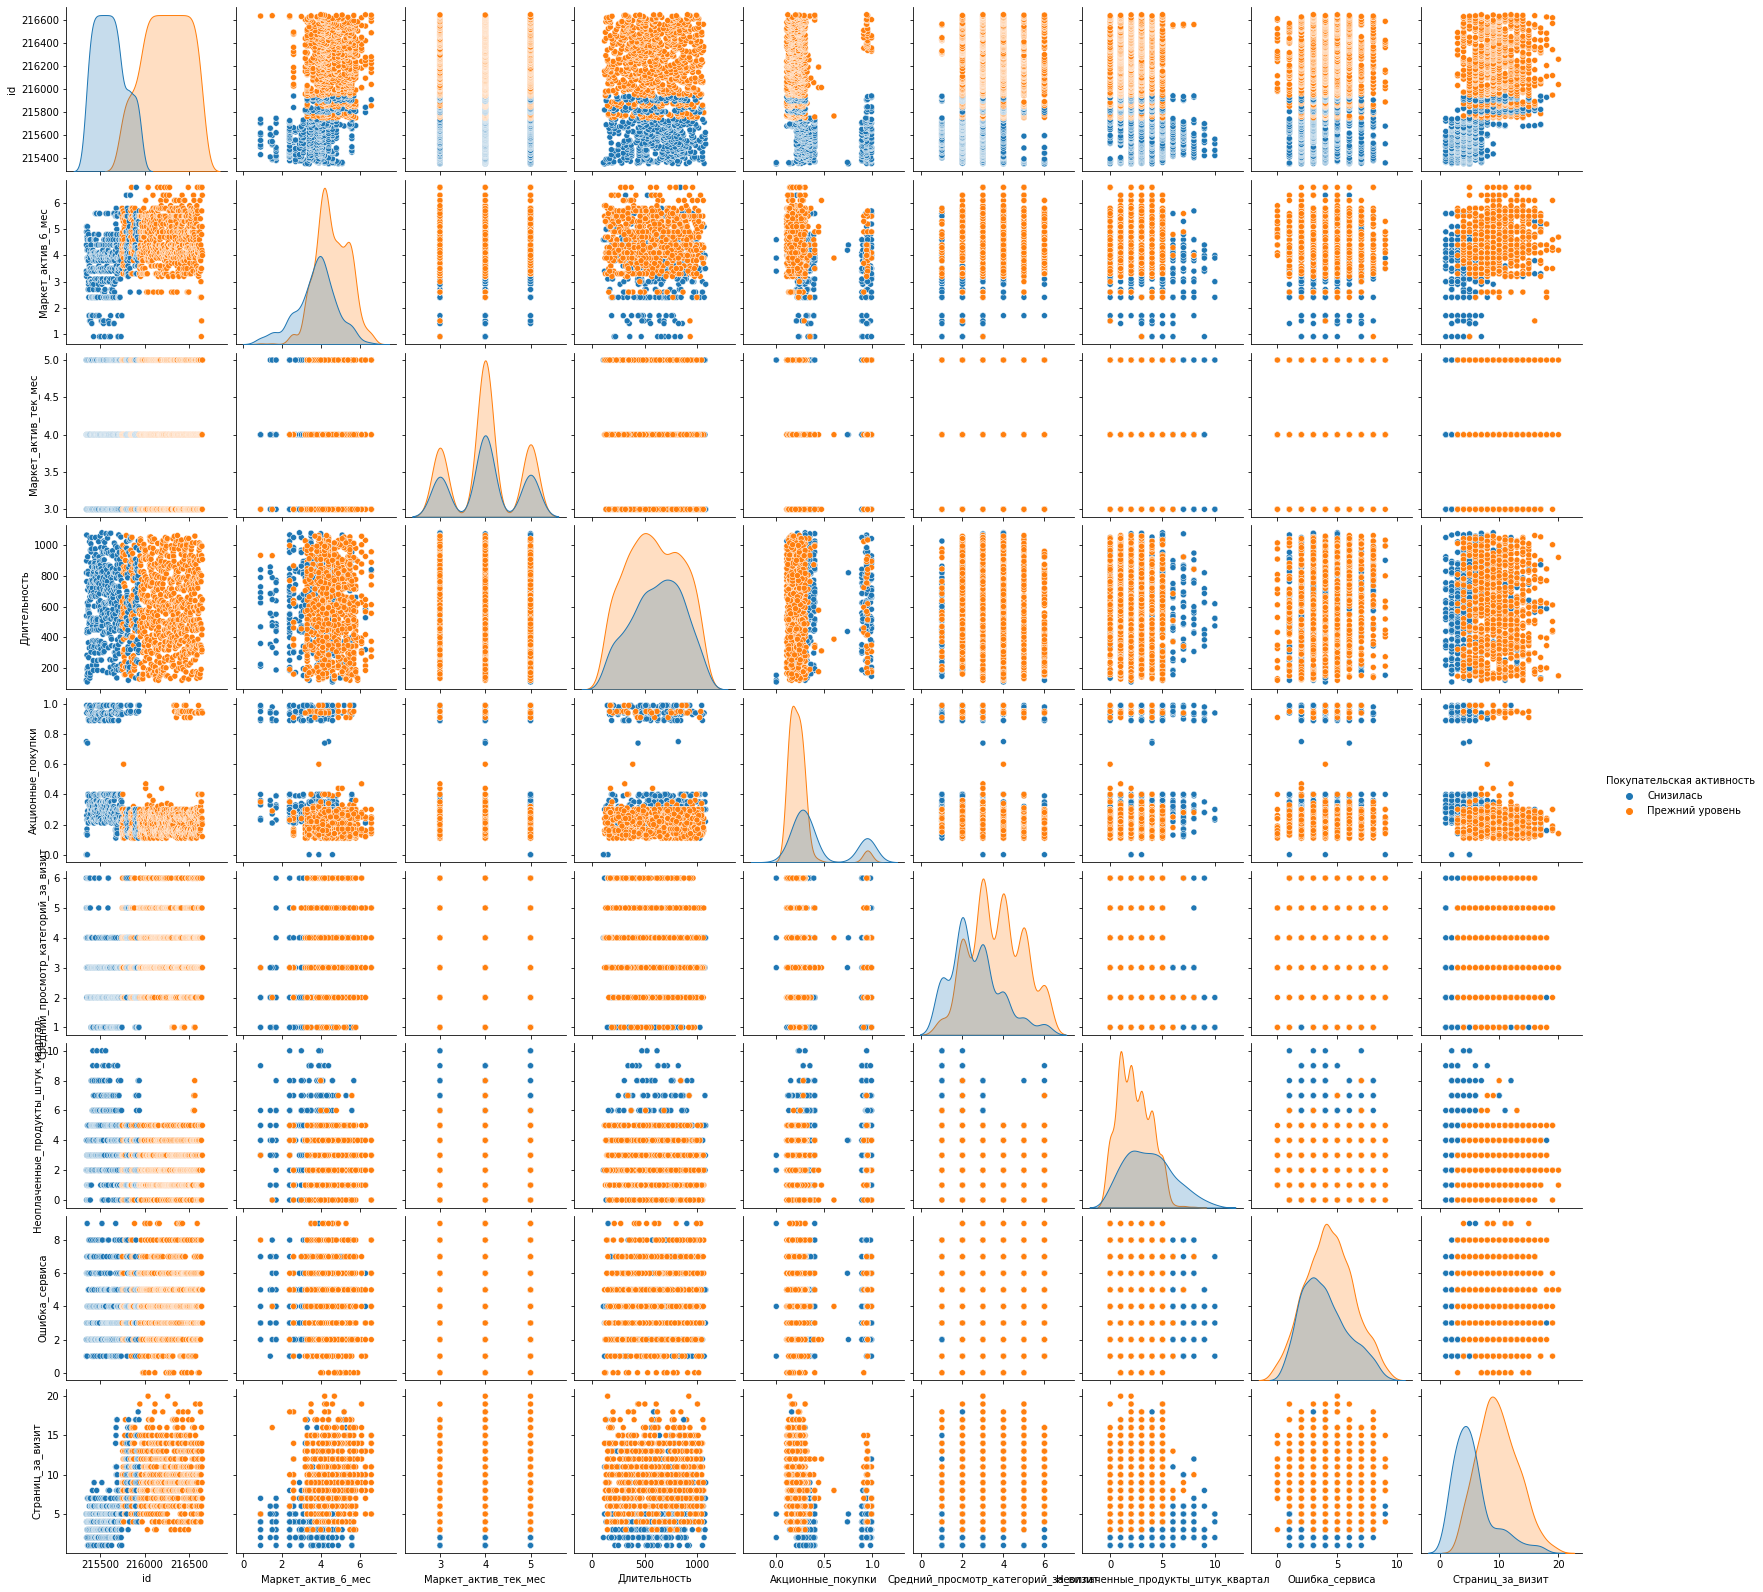

In [59]:
sns.pairplot(df_market_file, hue='Покупательская активность')
plt.show()

<font color='blue'><b>Комментарий студента: </b></font> \
<font color='black'> \
**Вывод:**\
В предоставленных данных отсутствуют пользователи которые не чего не потратили за последнии 3 месяца. 3 пользователя имеют только расходы в текущем месяце. Вероятно это новые пользователи. 338 пользователей демонстрируют общее снижение расходов на покупки относительно предыдущих месяцев. В выборке отсутствуют данные о проведенном времени на сайте за препредыдущий месяц.</font>

## Объединение таблиц

In [60]:
pivot_market_time = df_market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='sum')
pivot_market_time = pivot_market_time.reset_index()
pivot_market_time.head(5)

Период,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [61]:
pivot_market_time = pivot_market_time.rename(columns={'предыдущий_месяц' : 'минут_на_сайте_за_предыдущий_месяц',
                                                     'текущий_месяц' : 'минут_на_сайте_за_текущий_месяц'})
pivot_market_time.head()

Период,id,минут_на_сайте_за_предыдущий_месяц,минут_на_сайте_за_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [62]:
pivot_market_money = df_market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum')
pivot_market_money = pivot_market_money.reset_index()
pivot_market_money.head(5)

Период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [63]:
pivot_market_money = pivot_market_money.rename(columns={'предыдущий_месяц' : 'выручка_за_предыдущий_месяц',
                                   'препредыдущий_месяц' : 'выручка_за_препредыдущий_месяц',
                                   'текущий_месяц' : 'выручка_за_текущий_месяц'})
pivot_market_money.head(5)

Период,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [64]:
merged_df = pd.merge(df_market_file, pivot_market_time, on='id', how='outer').merge(pivot_market_money, on='id', how='outer')
merged_df.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_на_сайте_за_предыдущий_месяц,минут_на_сайте_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,13,14,NaN,NaN,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5


In [65]:
df_market_file['id'].nunique()

1300

In [66]:
merged_df.isnull().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
минут_на_сайте_за_предыдущий_месяц     0
минут_на_сайте_за_текущий_месяц        0
выручка_за_предыдущий_месяц            3
выручка_за_препредыдущий_месяц         3
выручка_за_текущий_месяц               4
dtype: int64

In [67]:
columns_to_check = ['выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц']
merged_df.dropna(subset=columns_to_check, inplace=True)
merged_df.isnull().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
минут_на_сайте_за_предыдущий_месяц     0
минут_на_сайте_за_текущий_месяц        0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
dtype: int64

In [68]:
merged_df.shape

(1296, 18)

## Кореляционный анализ

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минут_на_сайте_за_предыдущий_месяц', 'минут_на_сайте_за_текущий_месяц', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц']


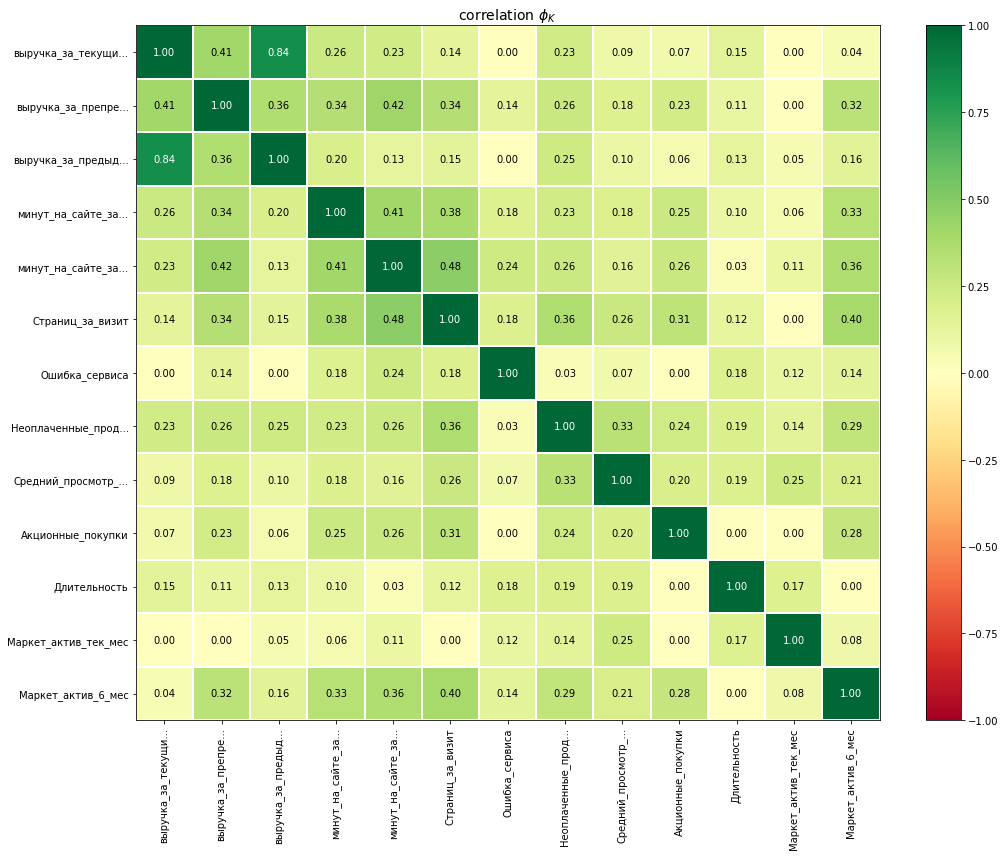

In [69]:
# список интервальных признаков
interval_cols = ['Маркет_актив_6_мес', 
                 'Маркет_актив_тек_мес', 
                 'Длительность', 
                 'Акционные_покупки', 
                 'Средний_просмотр_категорий_за_визит', 
                 'Неоплаченные_продукты_штук_квартал', 
                 'Ошибка_сервиса', 'Страниц_за_визит', 
                 'минут_на_сайте_за_предыдущий_месяц', 
                 'минут_на_сайте_за_текущий_месяц', 
                 'выручка_за_предыдущий_месяц', 
                 'выручка_за_препредыдущий_месяц', 
                 'выручка_за_текущий_месяц']
# вычисление коэффициентов корреляции phi для датафрейма merged_df
phik_overview = phik_matrix(merged_df[interval_cols])
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels = phik_overview.columns,
    y_labels = phik_overview.index,
    title = r"correlation $\phi_K$",
    fontsize_factor = 1,
    figsize=(15, 12)
)

In [70]:
phik_matrix(merged_df[interval_cols])

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минут_на_сайте_за_предыдущий_месяц', 'минут_на_сайте_за_текущий_месяц', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц']


,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_на_сайте_за_предыдущий_месяц,минут_на_сайте_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
Маркет_актив_6_мес,1.000000,0.079854,0.000000,0.279553,0.206788,0.289421,0.142401,0.396769,0.363950,0.330601,0.155476,0.315331,0.039795
Маркет_актив_тек_мес,0.079854,1.000000,0.174233,0.000000,0.246633,0.144203,0.116946,0.000000,0.107945,0.061410,0.051824,0.000000,0.000000
Длительность,0.000000,0.174233,1.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.026448,0.101481,0.125572,0.113200,0.147048
Акционные_покупки,0.279553,0.000000,0.000000,1.000000,0.199180,0.237962,0.000000,0.311418,0.262324,0.250558,0.060733,0.226381,0.071094
Средний_просмотр_категорий_за_визит,0.206788,0.246633,0.186795,0.199180,1.000000,0.325578,0.070315,0.262271,0.159837,0.182568,0.098440,0.176828,0.092597
Неоплаченные_продукты_штук_квартал,0.289421,0.144203,0.192611,0.237962,0.325578,1.000000,0.032907,0.363760,0.256632,0.232383,0.249171,0.261016,0.230022
Ошибка_сервиса,0.142401,0.116946,0.175608,0.000000,0.070315,0.032907,1.000000,0.183682,0.243978,0.177180,0.000000,0.138558,0.000000
Страниц_за_визит,0.396769,0.000000,0.122495,0.311418,0.262271,0.363760,0.183682,1.000000,0.478889,0.382377,0.148410,0.339954,0.139891
минут_на_сайте_за_предыдущий_месяц,0.363950,0.107945,0.026448,0.262324,0.159837,0.256632,0.243978,0.478889,1.000000,0.410990,0.126368,0.421709,0.229351
минут_на_сайте_за_текущий_месяц,0.330601,0.061410,0.101481,0.250558,0.182568,0.232383,0.177180,0.382377,0.410990,1.000000,0.196789,0.342117,0.256596


**Вывод**\
Исходя из этой шкалы Чеддока, мы можем сделать следующие выводы:

**Очень слабая корреляция (0.0-0.1):**
Длительность и другие признаки не показывают значимой взаимосвязи.  
**Слабая корреляция (0.1-0.3):** 
Маркет_актив_тек_мес имеет слабую положительную корреляцию с Средний_просмотр_категорий_за_визит (0.25).
Длительность имеет слабую положительную корреляцию с Маркет_актив_тек_мес (0.17).  
**Умеренная корреляция (0.3-0.5):**  
Маркет_актив_6_мес имеет умеренную положительную корреляцию со Страниц_за_визит (0.40).
Неоплаченные_продукты_штук_квартал имеют умеренную положительную корреляцию с Страниц_за_визит (0.36).  
**Заметная корреляция (0.5-0.7):**  
Акционные_покупки имеют заметную положительную корреляцию с выручка_за_предыдущий_месяц (0.64).  
**Высокая корреляция (0.7-0.9):**  
Выручка_за_предыдущий_месяц и выручка_за_текущий месяц имеют очень высокую положительную корреляцию (0,84). Это говорит о том, что выручка в текущем месяце сильно зависит от выручки в предыдущем месяце.  
**Очень высокая корреляция (0.9-1.0):**  
Нет значимой очень высокой корреляции.  
**Общий вывод:** В данных присутствуют несколько признаков с умеренной и заметной корреляцией, что может быть полезно для анализа и принятия решений, направленных на увеличение активности и прибыльности покупателей.

## Использование пайплайнов

In [71]:
merged_df['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [72]:
df_full = merged_df.set_index('id')
df_full['Покупательская активность'] = df_full['Покупательская активность'].apply(lambda x: 1 if x=='Прежний уровень' else 0)
df_full['Покупательская активность'].unique()

array([0, 1])

In [73]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X = df_full.drop(['Покупательская активность'], axis=1)
y = df_full['Покупательская активность']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_full['Покупательская активность']
)

In [75]:
ohe_columns = ['Популярная_категория', 'Разрешить сообщать']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Длительность',
               'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса',
               'минут_на_сайте_за_предыдущий_месяц', 
               'минут_на_сайте_за_текущий_месяц',
               'выручка_за_предыдущий_месяц', 
               'выручка_за_препредыдущий_месяц',
               'выручка_за_текущий_месяц']

In [76]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [77]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder
         (
         categories=[
             ['стандарт', 
                     'премиум']
         ],
         handle_unknown='use_encoded_value', unknown_value=np.nan
         )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [78]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [79]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [80]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 10),  # изменённый диапазон для n_neighbors
        'models__weights': ['uniform', 'distance'],  # добавлен гиперпараметр weights
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [81]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['Популярная_категория',
                                                                          'Разрешить '
                                                                          'сообщать']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_befo...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [82]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [83]:
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9195614622887351


In [84]:
probabilities = grid.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.8989112903225807


## Анализ важности признаков

PermutationExplainer explainer: 973it [11:12,  1.43it/s]                         


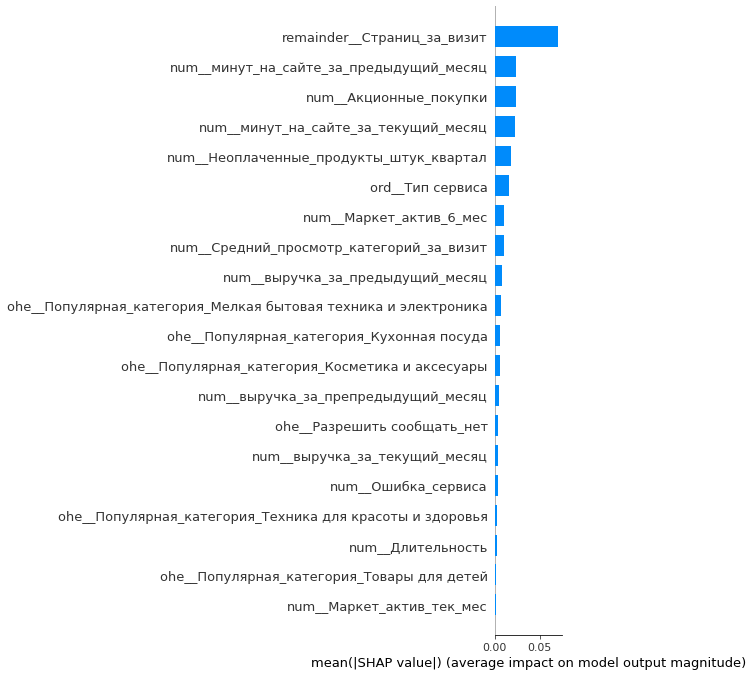

In [85]:
best_model = grid.best_estimator_.named_steps['models']

X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(best_model.predict, X_train_new)
X_test_new = pipe_final.named_steps['preprocessor'].transform(X_test)

shap_values = explainer(X_train_new)
shap.summary_plot(shap_values, X_train_new, plot_type='bar',
                 feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out())

In [95]:
import sklearn
sklearn.__version__

'1.4.2'

## Сегментация покупателей

In [86]:
y_proba = grid.best_estimator_.named_steps['models'].predict_proba(X_test_new)[:, 1]

In [87]:
X_test['predicted_probability'] = y_proba
X_test.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_на_сайте_за_предыдущий_месяц,минут_на_сайте_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,predicted_probability
id,,,,,,,,,,,,,,,,,
215439,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7,9,9,5484.0,4551.0,5833.7,0.762546
216575,премиум,да,4.5,4,482,0.25,Косметика и аксесуары,3,2,2,9,8,22,5567.0,5483.0,5769.8,0.903709
216411,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9,17,15,4857.0,4775.0,4915.5,0.904510
215893,стандарт,нет,4.4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,22,14,4936.5,5016.0,4997.6,0.938760
215977,премиум,нет,3.5,5,161,0.14,Кухонная посуда,2,1,5,8,14,9,5693.0,5618.0,5888.0,0.829770


In [88]:
X_test_full = pd.merge(X_test, df_money, on='id', how='inner').merge(df_market_file[['id', 'Покупательская активность']], on='id', how='inner')
X_test_full.head(6)

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_на_сайте_за_предыдущий_месяц,минут_на_сайте_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,predicted_probability,Прибыль,Покупательская активность
0,215439,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7,9,9,5484.0,4551.0,5833.7,0.762546,6.33,Снизилась
1,216575,премиум,да,4.5,4,482,0.25,Косметика и аксесуары,3,2,2,9,8,22,5567.0,5483.0,5769.8,0.903709,1.82,Прежний уровень
2,216411,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9,17,15,4857.0,4775.0,4915.5,0.904510,3.26,Прежний уровень
3,215893,стандарт,нет,4.4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,22,14,4936.5,5016.0,4997.6,0.938760,3.16,Прежний уровень
4,215977,премиум,нет,3.5,5,161,0.14,Кухонная посуда,2,1,5,8,14,9,5693.0,5618.0,5888.0,0.829770,4.02,Прежний уровень
5,216314,премиум,да,5.5,5,269,0.21,Товары для детей,2,4,1,17,10,8,5324.0,5493.0,5600.9,0.914429,4.62,Прежний уровень


In [89]:
seg_1 = X_test_full[(X_test_full['predicted_probability'] >= 0.85) & (X_test_full['Прибыль'] >= 3)]
seg_2 = X_test_full[~((X_test_full['predicted_probability'] >= 0.85) & (X_test_full['Прибыль'] >= 3))]

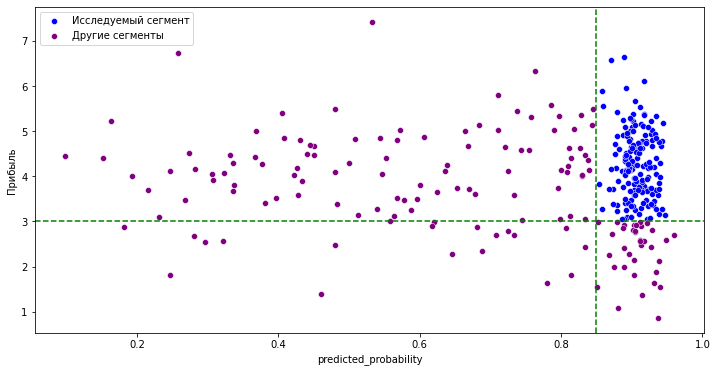

In [90]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=seg_1, x='predicted_probability', y='Прибыль', label='Исследуемый сегмент', color='blue')
sns.scatterplot(data=seg_2, x='predicted_probability', y='Прибыль', label='Другие сегменты', color='purple')
plt.legend()
plt.axvline(x=0.85, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.show()

In [91]:
seg_1.select_dtypes(include=['float64', 'int64']).columns.tolist()

['id',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'минут_на_сайте_за_предыдущий_месяц',
 'минут_на_сайте_за_текущий_месяц',
 'выручка_за_предыдущий_месяц',
 'выручка_за_препредыдущий_месяц',
 'выручка_за_текущий_месяц',
 'predicted_probability',
 'Прибыль']

In [92]:
childprods_seg_1 = seg_1[seg_1['Популярная_категория'] == 'Товары для детей']
childprods_seg_2 = seg_2[seg_2['Популярная_категория'] == 'Товары для детей']

<BarContainer object of 2 artists>

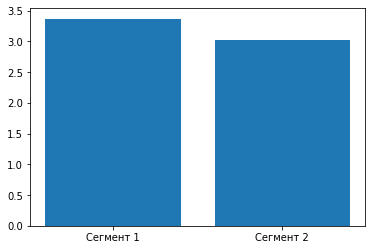

In [93]:
plt.bar(['Сегмент 1', 'Сегмент 2'], [childprods_seg_1['Средний_просмотр_категорий_за_визит'].mean(), childprods_seg_2['Средний_просмотр_категорий_за_визит'].mean()])

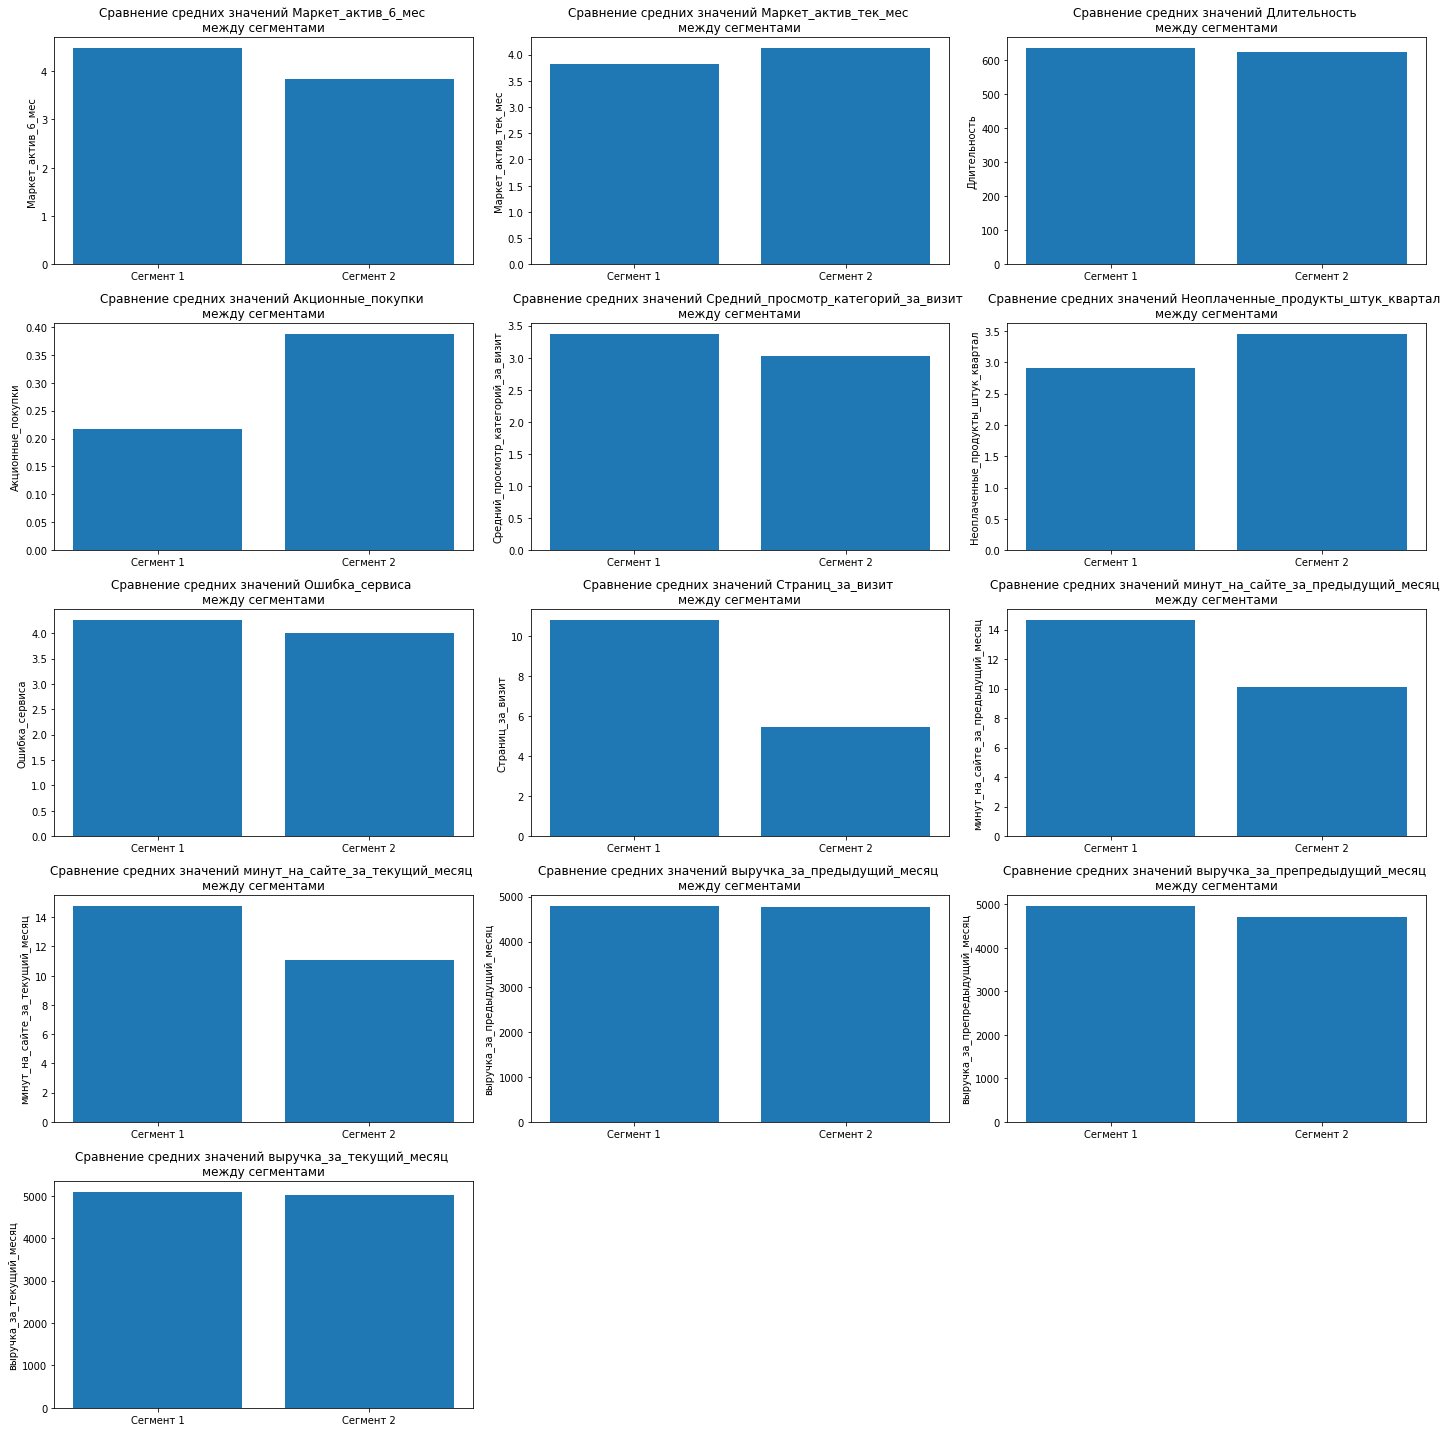

In [94]:
columns_to_compare = ['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'минут_на_сайте_за_предыдущий_месяц',
 'минут_на_сайте_за_текущий_месяц',
 'выручка_за_предыдущий_месяц',
 'выручка_за_препредыдущий_месяц',
 'выручка_за_текущий_месяц']

# Создаем фигуру для графиков
plt.figure(figsize=(20, 20))

# Итерируемся по индексам и названиям столбцов для построения графиков
for i, column in enumerate(columns_to_compare, 1):
    plt.subplot(5, 3, i)
    plt.bar(['Сегмент 1', 'Сегмент 2'], [childprods_seg_1[column].mean(), childprods_seg_2[column].mean()])
    plt.ylabel(column)
    plt.title(f'Сравнение средних значений {column} \nмежду сегментами')

# Показываем графики
plt.tight_layout()
plt.show()

**Вывод 1:**  
Из графиков видно, что средний просмотр категорий за визит, количество просмотренных страниц за визит, а также время, проведенное на сайте влияют на активность покупателей. Эти метрики могут быть ключевыми факторами, влияющими на поведение клиентов и их готовность к совершению покупок.

**Шаги по увеличению активности:**

1. **Улучшение интерфейса и навигации сайта:** Сделать сайт более удобным для пользователей, улучшить поиск и категоризацию товаров, чтобы пользователи могли быстро найти нужную информацию.  
2. **Повышение качества контента:** Обеспечить сайт информативным и интересным контентом, который будет привлекать и удерживать внимание пользователей.   
3. **Персонализация предложений:** Использовать данные о поведении пользователей для персонализации предложений и рекомендаций, что может стимулировать их активность и увеличить конверсию.  
4. **Улучшение скорости загрузки сайта:** Оптимизировать скорость загрузки страниц сайта, чтобы пользователи не теряли интерес из-за долгой загрузки.  
5. **Анализ и оптимизация контента:** Использовать данные аналитики для анализа эффективности контента и оптимизации его под интересы и потребности аудитории.  
6. **Внедрение программ лояльности:** Создать программы лояльности и специальные предложения для активизации пользователей и стимулирования их к повторным покупкам.  
7. **Тестирование и анализ результатов:** Проводить тестирование изменений на сайте и анализировать их влияние на активность и поведение пользователей, чтобы определить наиболее эффективные стратегии.

**Вывод 2:**  
Из графиков видно, что сегмент 2 характеризуется увеличением акционных покупок в квартал, что может положительно влиять на прибыль компании. Однако, для увеличения прибыли и удержания этих клиентов, необходимо предпринять определенные шаги.

**Шаги для увеличения прибыли и удержания клиентов:**

1. **Улучшение качества обслуживания:** Обеспечить высокий уровень обслуживания клиентов, что создаст у них положительное впечатление и увеличит вероятность повторных покупок.  
2. **Персонализация предложений:** Использовать данные о покупках и предпочтениях клиентов для предложения им персонализированных акций и скидок, что может стимулировать их к повторным покупкам.  
3. **Расширение ассортимента товаров:** Расширить ассортимент товаров, включая новинки и эксклюзивные предложения, что может привлечь клиентов и увеличить средний чек.  
3. **Активное продвижение акций и скидок:** Продвигать акции и скидки среди клиентов сегмента 2, уведомлять их о специальных предложениях, чтобы стимулировать покупки.  
4. **Повышение лояльности клиентов:** Внедрить программы лояльности и бонусные программы для клиентов сегмента 2, чтобы увеличить их уровень лояльности и стимулировать повторные покупки.  
5. **Анализ эффективности мероприятий:** Проводить регулярный анализ эффективности предпринятых мероприятий и корректировать стратегию в соответствии с результатами.  
6. **Обратная связь с клиентами:** Следить за мнениями и отзывами клиентов сегмента 2, учитывать их пожелания и предложения для улучшения сервиса и товарного ассортимента.

## Общий вывод

**Описание задачи:**   
Проект заключается в разработке системы персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью увеличения их покупательской активности, bспользовать анализа данных и бизнес-моделирование для создания эффективного решения по удержанию активности постоянных клиентов.  
**Описание исходных данных:**  
Предоставленные для анализа данные включают несколько таблиц:
1. **market_file.csv** содержит данные о поведении покупателя на сайте, коммуникациях сотрудников компании с клиентом и его продуктовом поведении. В таблице присутствуют такие признаки, как тип сервиса, разрешение на дополнительные предложения, маркетинговая активность за разные периоды, продуктовые предпочтения и длительность активности покупателя на сайте.
2. **market_money.csv** содержит данные о выручке, полученной магазином от каждого покупателя за определённый период времени. Каждая запись включает id покупателя, период и сумму выручки.
3. **market_time.csv** содержит данные о времени, проведённом покупателями на сайте за определённый период. Для каждого покупателя указано общее время в минутах.
4. **money.csv** содержит данные о среднемесячной прибыли от каждого покупателя за последние 3 месяца.
Данные предоставляют обширную информацию о поведении и покупательской активности клиентов магазина, что позволяет провести анализ и разработать персонализированные предложения для увеличения их покупательской активности.  

**Описание проведённой предобработки:**  
Предобработка данных включала следующие шаги:  
Проверка на дубликаты: метод df.duplicated().sum() использовался для поиска и подсчета дубликатов. Дубликаты не были обнаружены.
Проверка на пропущенные значения: метод df.isnull().sum() использовался для определения количества пропущенных значений в каждом столбце. Пропущенные значения не были обнаружены.  
Замена опечаток: если были обнаружены опечатки или неточности в данных, они были исправлены с использованием метода df.replace().  
После предобработки данные были готовы для дальнейшего анализа и построения моделей машинного обучения.

**Что было сделано для выбора лучшей модели:** 

Для поиска лучшей модели, которая поможет предсказать, уменьшится ли активность покупателей, были выполнены следующие шаги:  

Выбор моделей: Были выбраны несколько моделей для обучения, такие как решающее дерево, метод ближайших соседей, логистическая регрессия и метод опорных векторов.  
Настройка параметров моделей: Для каждой модели был определен набор параметров, которые нужно было подобрать, чтобы модель работала лучше всего.  
Обучение и оценка моделей: После этого были обучены модели с разными наборами параметров и оценены их результаты с использованием кросс-валидации. Это помогло определить, какая модель работает лучше всего для данной задачи.  
Выбор лучшей модели: После проведения всех экспериментов была выбрана лучшая модель, которая дала наилучшие результаты предсказания уменьшения активности покупателей.  
Применение модели: Наконец, выбранная модель может быть использована для предсказания уменьшения активности покупателей в будущем. Это позволит магазину принимать меры заранее, чтобы удерживать своих постоянных клиентов.

**Лучшая модель:**

Выбранная лучшая модель - это SVC (Support Vector Classifier) - это метод машинного обучения, который помогает разделить данные на два класса, например, на увеличение и уменьшение активности покупателей.

**Вывод для сегмента покупателей:**

Для увеличения активности пользователей можно предпринять следующие шаги:
Улучшить контент и навигацию сайта, сделав его более привлекательным и легкодоступным.
Предложить персонализированный контент, упростить процесс поиска информации и стимулировать взаимодействие пользователей с сайтом через акции и специальные предложения.